# Exercise Session: k-Nearest Neighbors Classifier  (Solutions)

In this exercise, you will implement the **$k$-Nearest Neighbors classifier (k-NN)**. You will also review other important concepts related to machine learning in practice,
including data preprocessing, distance metrics, visualization, and model evaluation.

We have provided general functionality and pointers for you here. Please complete the code with your implementation below. Please also discuss and answer the follow-up questions.

### 1. Dataset and problem description

The Healthy Body dataset contains body measurements acquired from **1250 people _of different ages, genders, and nationalities_** from different hospitals around the world. Health professionals have performed medical examinations and classified the individuals into three different body categories: **underweight, normal weight, and overweight.**

#### Problem. 
Our goal is to automate the role of the health professionals, i.e., to predict the category of the new data. However, due to anonymity reasons, we have been provided access to limited information about the individuals: their measured **_weights, heights_** and their respective **_body category_** only.
 
We will use these features to train a **k-NN classifier** for the task.

---

In [1]:
# Enable interactive plots, so you can zoom/pan/resize plots
%matplotlib inline

# Libraries for numerical handling and visualization
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(0)

## 2. Data loading  and visualization


In [2]:
# Weights, heights of individuals and their associated body category 
features_annotated_path = "./hbody_feats_annotated.npy"     
labels_annotated_path   = "./hbody_labels_annotated.npy"      

# Weights and heights of  individuals with unknown body category 
# Task: Figure out their body category label using k-NN classifier
features_unannotated_path = "./hbody_feats_unannotated.npy" 

# ground-truth body categories of  individuals with unknown body category  
# to evaluate the k-NN classifier
labels_unannotated_path = "./hbody_labels_unannotated_secret.npy"     

# Features organized in an NxD matrix: N examples and D features.
# Another way to look at it: each of the N examples is a D-dimensional feature vector.

data_train   = np.load(features_annotated_path)
data_test    = np.load(features_unannotated_path)
labels_train = np.load(labels_annotated_path)
labels_test  = np.load(labels_unannotated_path)

class_names = ('Underweight', 'Normal weight', 'Overweight')


**Q1. What are our labels? What are the features that we use to predict these labels?**

**Answer**: 

**Labels:** underweight, normal weight, overweight

**Features:** height and weight



### 2.1 Data Summary

Number of examples in the training set  : 937
Number of examples in the test set      : 313


Text(0.5, 1.0, 'Histogram plot of each body category in the training set')

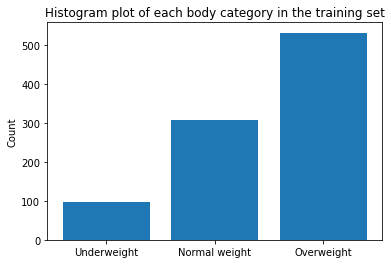

In [3]:
print("Number of examples in the training set  : {}".format(data_train.shape[0]))
print("Number of examples in the test set      : {}".format(data_test.shape[0]))

plt.bar(class_names, np.bincount(labels_train))
plt.ylabel('Count')
plt.title('Histogram plot of each body category in the training set')

### 2.2 Data visualization

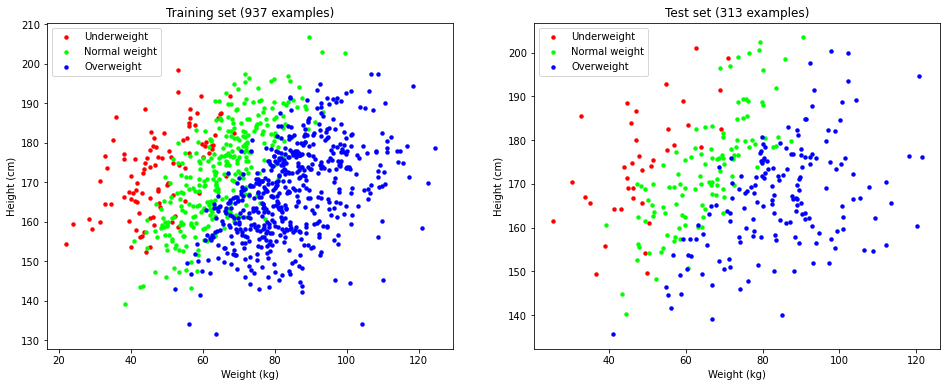

In [4]:
colors = np.array([[1.0, 0.0, 0], 
                   [0, 1.0, 0], 
                   [0.0, 0.0, 1]])

plt.figure(figsize=(16,6))

# visualize the training set
plt.subplot(1,2,1)
plt.title(f"Training set ({len(labels_train)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*data_train[labels_train==i].T,
                c=colors[i, None], alpha=1.0, 
                s=20, lw=0, label=class_name)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();

# visualize the test set
plt.subplot(1,2,2)
plt.title(f"Test set ({len(labels_test)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*data_test[labels_test==i].T,
                c=colors[i, None], alpha=1.0, 
                s=20, lw=0, label=class_name)
    
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();
plt.show()

**Q2. Do you think this is an easy or a difficult classification problem? Why?**  

**Answer:** Except for amibiguities at the class boundaries, the classes are separated from each other, and learning to separate the classes will be easy or difficult depending on how much mis-classification we would like to allow.

**Q3. What should the test set share in common with the training set?**  

**Answer:** Both should come from a similar data distribution.


## 3. Normalizing the data

k-NN determines neighbors by computing the "distance" between two examples. For this process to work, we are required to normalize the features. This is true for many other machine learning algorithms as well.

**Q. What would happen if we don't do this?**  
**A.** Different features will have a different range of values. For example, if we have a feature corresponding to the salary of a person vs his/her weight. The salary will be in the order of $10^5$ whereas the weight will be less than $10^2$. This means that, while computing distances between two data points, the salary will overpower the computation. Furthermore, without proper normalization, iterative algorithms might take more time to converge.

A common way to normalize the data is by the so-called z-score standardization. It transforms values from an arbitrary range such that the results have mean $0$ and standard deviation $1$. 

The operation is defined as follows:

$$
x_{norm} = \frac {x - \mu_x} {\sigma_x},
$$

for _each feature x independently_  using its mean $\mu_x$ and standard deviation $\sigma_x$.


In [5]:
def normalize(data, means, stds):
    """This function takes the data, the means,
    and the standard deviatons(precomputed). It 
    returns the normalized data.
    
    Inputs:
        data : shape (NxD)
        means: shape (1XD)
        stds : shape (1xD)
        
    Outputs:
        data_normed: shape (NxD)
    """
    # WRITE YOUR CODE HERE
    # return the normalized features
    return (data - means) / stds

# test the  normalize function 
dummy_features = np.random.randint(100,size=(10,3))
means = dummy_features.mean(0,keepdims=True)
stds  = dummy_features.std(0,keepdims=True)
dummy_features_normed = normalize(dummy_features, means, stds)

if (np.allclose(dummy_features_normed.mean(axis=0), 0) and 
    np.allclose(dummy_features_normed.std(axis=0), 1)):
    print("Everything alright here!!")
else:
    print("Try again.")

Everything alright here!!


## 4. The $k$-Nearest Neighbors Classifier

The k-NN classifier assigns the most common label among its k-nearest neighbors for a given example. The method is very intuitive and can be summarized as:
- Compute the distance between the example to classify and all the training examples.
- Select the closest $k$ training examples.
- Assign to the example the most common label among those neighbors.

### 4.1 Distance metrics

There are many ways to define a distance between two examples. We introduce a very common distance metric, the Euclidean distance. 

#### Euclidean distance:

$$
D(\mathbf{v}, \mathbf{w}) = \sqrt{ \sum_{i=1}^D \left(\mathbf{v}^{(i)} - \mathbf{w}^{(i)}\right)^2 }
$$

This is the generalization of the Pythagorean theorem to an arbitrary number of dimensions $D$ and corresponds to our intuitive interpretation of the straight-line distance between two vectors $\mathbf{v}\in\mathbf{R}^D$ and $\mathbf{w}\in\mathbf{R}^D$. Note that $\mathbf{v}^{(i)}$ denotes the value in the dimension $i$ of $\mathbf{v}$.



In [6]:
def euclidean_dist(example, training_examples):
    """function to compute the Euclidean distance between a single example
    vector and all training_examples

    Inputs:
        example: shape (D,)
        training_examples: shape (NxD) 
    Outputs:
        return distance vector of length N
    """
    
    ##############
    # You are expectedz to implement this yourselves for the project
    # WRITE YOUR CODE HERE
    
    ##############
    
    return distance

In [7]:
def find_k_nearest_neighbors(k, distances):
    """ Find the indices of the k smallest distances from a list of distances.
        Tip: use np.argsort()
    """
    
    ##############
    # You are expected to implement this yourselves for the project
    
    # WRITE YOUR CODE HERE

    ##############
    
    return indices

# test the find_k_nearest_neighbors function
dummy_distances = [10., 0.5, 200, 0.006, 43, 4.5, 11., 50]
top_k = 5
top_k_indices = find_k_nearest_neighbors(top_k,dummy_distances)

if np.allclose(top_k_indices,[3,1,5,0,6]):
    print('Implementation is correct')
else:
    print('Oops!! Something is wrong')
        

Implementation is correct


In [8]:
# Given a list of neighbor labels, choose the most frequent one.
# Tip: np.bincount and np.argmax are your friend.

def predict_label(neighbor_labels):
    """return the most frequent element in the input.
    """
    # WRITE YOUR CODE HERE
    return np.argmax(np.bincount(neighbor_labels))

# test label prediction
dummy_labels = [10, 3, 2, 10, 2, 2, 2, 10, 10, 11, 1, 2]

if predict_label(dummy_labels) == 2:
    print('Implementation is correct')
else:
    print('Oops!! Something is wrong')


Implementation is correct


### 4.2 $k$-NN classifier, step by step for a single test example

Let's implement the algorithm for **one data sample**.

**Q4.You are asked to use the training set's mean and std to normalize the data. Can you explain the reasoning behind this?** 

**Answer** We are not supposed to know anything about the test set during the training phase. Therefore, we use training set's mean and std to normalize the entire dataset, including test data. We can do this since we assume that the statistics of the training and test are the same, meaning that the samples are drawn from the same distribution.



In [9]:
def choose_random_sample(data):
    """randomly chose a single datapoint from the given data matrix.
    Input:
        data: shape (NxD)
    Output:
        return a randomly chosen sample of length (D,)
    """
    
    # WRITE YOUR CODE HERE
    total_samples = data.shape[0]
    sample =  data[np.random.choice(np.arange(total_samples),1)[0],:]
    return sample

In [10]:
# Use the functions you just defined to predict the label of a single example

# Choosing a random test example 
single_test_data =  choose_random_sample(data_test)



# IMPORTANT: Normalize the data, what should be the mean and std? 
# mean_val and std_val dimension should be (1x2)

# WRITE YOUR CODE HERE

mean_val = data_train.mean(axis=0, keepdims=True)
std_val = data_train.std(axis=0, keepdims=True)

# norm_train is the normalized data_train
norm_train = normalize(data_train, mean_val, std_val)

# norm_test_single is the normalized single_test_data
norm_test_single = normalize(single_test_data, mean_val, std_val)

# set the number of neighbors in the kNN classifier (hyperparameter)
k = 6

##############
# You are expected to implement this yourselves for the project

# find distance of the single test example w.r.t. all training examples
distances = ...

# find the nearest neighbors
nn_indices = ...

# find the labels of the nearest neighbors
neighbor_labels = ...

print("Nearest {} neighbors' labels: {}\n".format(k, ", ".join([class_names[x] for x in neighbor_labels])))

# find the best label
best_label = ...

##############

print(f'Predicted label: {class_names[best_label]}')

Nearest 6 neighbors' labels: Overweight, Overweight, Overweight, Overweight, Overweight, Overweight

Predicted label: Overweight


##### The cell below is for visualization.

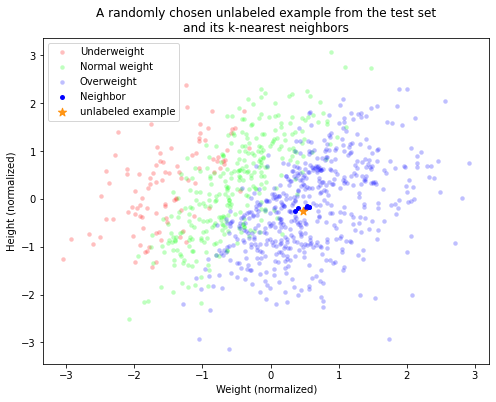

In [11]:
# Visualize the unknown point and its neighbors.
plt.figure(figsize=(8, 6))

plt.title(f"A randomly chosen unlabeled example from the "
          "test set\nand its k-nearest neighbors")

for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train[labels_train==i].T,
                c=colors[i, None], alpha=0.25, 
                s=20, lw=0, label=class_name)
    
for i, class_name in enumerate(class_names):
    class_indices = nn_indices[labels_train[nn_indices] == i]
    if len(class_indices) > 0:
        plt.scatter(*norm_train[class_indices].T,
                    c=colors[i, None], alpha=1, 
                    s=25, lw=0, label='Neighbor')

# Make sure the norm_test is 1D vector.
plt.scatter(*norm_test_single.reshape((-1)), marker='*', c='darkorange', 
                 alpha=.9, s=75, label='unlabeled example')

plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

### 4.3 Performance metrics

To quantify the performance of our model, we want to obtain a score that tells us how close the predictions were to the expected classification.

The simplest way to do this is to compute the ratio of correctly predicted examples, also known as the accuracy:

$$
\frac 1 N \sum_{n=1}^N \mathbf{1}[\hat{y} = y]
$$

where the indicator function $\mathbf{1}[\hat{y} = y]$ returns 1 if the predicted $\hat{y}$ is equal to the ground-truth $y$ and returns 0 otherwise.

**Q5. Do you see any limitation to using accuracy to evaluate your model?**

**Answer.** By using accuracy only, we do not care what particular mistakes the model made. One can argue that incorrectly labeling an overweight person as underweight is worse than labeling them as normal weight. Also, if most people belonged to one class, just predicting that class for the whole population would give a very high accuracy. Plain accuracy does not account for class imbalances.

**Q6. Can you think of other ways to evaluate your model?**

**Answer.** There are many. Qualitatively, one could inspect what mistakes the model made, by computing a confusion matrix: a matrix counting all the predictions and expected labels. One could improve the accuracy metric by assigning weights to each example related to its class frequency: the more uncommon a class is, the more important it is that the model classifies correctly the examples belonging to such class.
 

**Q7. Is accuracy suitable for multi-class classification?** 

**Answer.** Plain accuracy is not as suitable as other metrics like F-score, Confusion Matrix, Balanced Accuracy Rate or ROC for multiclass classification. 


**Q8. What other criteria, aside from accuracy, should one consider when choosing hyperparameters?**  

**Answer.** One other criterion is model complexity. When possible, one should choose simpler models over more complicated ones. Other criteria include robustness, speed, and scalability. 



In [12]:
# Write a function that computes the accuracy between a predicted and the expected labels.
def compute_accuracy(predicted, target):
    """returns the accuracy score.
    """
    
    # WRITE YOUR CODE HERE
    return np.mean(predicted == target)

### 4.4 Putting things together to run the k-NN classifier for all examples

Let's implement the algorithm for **all data samples**.


In [13]:
# Write a function kNN_one_example that applies all the previous steps
# to predict the label of 'one' example.

def kNN_one_example(unlabeled_example, training_features, training_labels, k):
    """returns the label of single unlabelled_example.
    """
    
    
    ##############
    # You are expected to implement this yourselves for the project
    
    # WRITE YOUR CODE HERE
    # Compute distances
    distances = ...
    
    # Find neighbors
    nn_indices = ...  
    
    # Get neighbors' labels
    neighbor_labels = ...
    
    # Pick the most common
    best_label = ...
    
    ##############
    
    return best_label

In [14]:
# Write a function kNN that applies 'kNN_one_example' function to an arbitrary number of examples.
# Tip: NumPy's apply_along_axis does most of the work for you. It's a one-liner!

def kNN(unlabeled, training_features, training_labels, k):
    """return the labels vector for all unlabeled datapoints.
    """
    
    # WRITE YOUR CODE HERE
    return np.apply_along_axis(func1d=kNN_one_example, axis=1, arr=unlabeled, 
                               training_features=training_features, 
                               training_labels=training_labels, k=k)

Test Accuracy is 83.4%


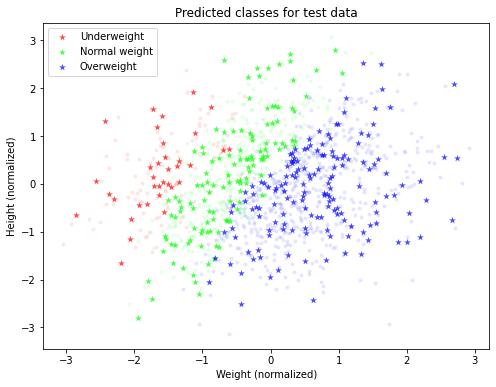

In [15]:
# Normalize your training data and  test data
# don't forget to normalize according to the mean and std of the training set

mean_val = data_train.mean(axis=0,keepdims=True)
std_val  = data_train.std(axis=0,keepdims=True)
norm_train_data = normalize(data_train,mean_val,std_val)
norm_test_data  = normalize(data_test,mean_val,std_val)

#choose a k value
k = 6

# run k-NN classifier on complete test data
predicted_labels_test = kNN(norm_test_data, norm_train_data, labels_train, k)

accuracy = compute_accuracy(predicted_labels_test, labels_test)
print("Test Accuracy is {:.1f}%".format(100*accuracy))

# Visualize the predictions on the unannotated test set
plt.figure(figsize=(8,6))
plt.title("Predicted classes for test data")

for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_data[labels_train==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
    
# represent test set by '*' marker
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_test_data[predicted_labels_test==i].T,
                c=colors[i, None], marker='*', alpha=0.7, 
                s=50, lw=0, label=class_name)
    
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

**Q9. While the above implementation works, it has some drawbacks. Can you identify them?**  

**Answer.** Since we are calculating the distance of a point w.r.t. all the other points, we will have duplicate computations since D(a,b) = D(b,a) for most of the distance metrics (D) for points (a, b). Additionally, data points are ordered in space and when using a distance metric like the Euclidean one, one have an ordering property. If a point A is further away from point B than point C, then a new point P, if further away from point A, is also further away from point B. Hence, one can skip the distance calculation with w.r.t. P and B, leading to fewer computations.

**Q10. How do you expect the model to perform with large k values equal to the number of training example ?**

**Answer.** For large values of k, the k-NN classifier predicts the label of the most frequent class in the training set.


**Q11. What should one take into account when feeding new data to a machine learning model?**

**Answer.** The same-distribution assumption. This in practice also means that any transformation we applied on the training data, such as the data normalization operation that we applied above, should be applied in the same way to all the rest of the data.